## English Protected Areas ##

For Download go to:<br>
Special Protection Areas England: https://naturalengland-defra.opendata.arcgis.com/datasets/Defra::special-protection-areas-england/about
<br> Special Areas of Conservation England: https://naturalengland-defra.opendata.arcgis.com/datasets/Defra::special-areas-of-conservation-england/about
<br> Marine Conservation Zones (England): https://naturalengland-defra.opendata.arcgis.com/datasets/Defra::marine-conservation-zones-england/about

In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import geopandas as gpd
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import cartopy.crs as ccrs
from cartopy.crs import PlateCarree as plate
import cartopy.io.shapereader as shpreader

import xarray as xr
import atlite

import logging
import warnings

warnings.simplefilter('ignore')
logging.captureWarnings(False)
logging.basicConfig(level=logging.INFO)

import numpy as np
from shapely.geometry import Polygon


In [2]:
spa= gpd.read_file(r"..\data\Special_Protection_Areas_England_4749058353884429990\Special_Protection_Areas_(England)___Natural_England.shp")
spa1= spa.copy()

sac=  gpd.read_file(r"..\data\Special_Areas_of_Conservation_England_-889645401271580412\Special_Areas_of_Conservation_(England)___Natural_England.shp")
sac1 =sac.copy()

marin= gpd.read_file(r"..\data\Marine_Conservation_Zones_(England)\Marine_Conservation_Zones___Natural_England_and_JNCC.shp")
marin1= marin.copy()

In [3]:
marin1.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    103 non-null    int64   
 1   MCZ_NAME    103 non-null    object  
 2   MCZ_CODE    103 non-null    object  
 3   MCZ_AREA    103 non-null    float64 
 4   GRID_REF    103 non-null    object  
 5   EASTING     103 non-null    float64 
 6   NORTHING    103 non-null    float64 
 7   LATITUDE    103 non-null    object  
 8   LONGITUDE   103 non-null    object  
 9   STATUS      103 non-null    object  
 10  GIS_DATE    103 non-null    object  
 11  SHAPE_Leng  103 non-null    float64 
 12  SHAPE_Area  103 non-null    float64 
 13  geometry    103 non-null    geometry
dtypes: float64(5), geometry(1), int64(1), object(7)
memory usage: 11.4+ KB


In [4]:
marin1.crs

<Derived Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

The limits are the resulting delimitations of the cutout.<br>
Result of cells.unary_union.bounds.Input coordinates of the cutout were farther apart.


In [5]:
limits= np.array([-4.375, 51.375, 10.125, 60.875])
xmin, xmax= (-4.375, 10.125)
ymin, ymax= (51.375, 60.875)
lat_point_list = [ymin, ymax, ymax,ymin,ymin]
lon_point_list = [xmin, xmin ,xmax ,xmax, xmin ]
original_polygon = Polygon(zip(lon_point_list, lat_point_list))
polygon = Polygon([original_polygon.boundary.interpolate(i, normalized=True) for i in np.linspace(0, 1, 10000)])
poly = gpd.GeoDataFrame(['Selection'], geometry=[polygon], crs=4326)
#poly.iloc[0].geometry.wkt

#ohne die Interpolation wird das Polygon erstmal mit vier Eckpunkten erstellt
#nach der Transoframtion in 3035 würden diese vier Punkte korrekt auf den GLobus gesetzt
#aber die Verbindung ist naiv auf dem kürzesten Wege und beachtet nicht mehr die RIchtung ( verläuft nicht mehr entlang des Längen und Breitengrads
# deswegen fügt man durch Interpolate viel mehr Punkte entlang der WEgstrecke zurück --> die Verzerrung gilt nur nich für minimal WEgstücke
#Alternative wäre: man nimmt die Cells( unary_union) aus der Main-Datei

<AxesSubplot:>

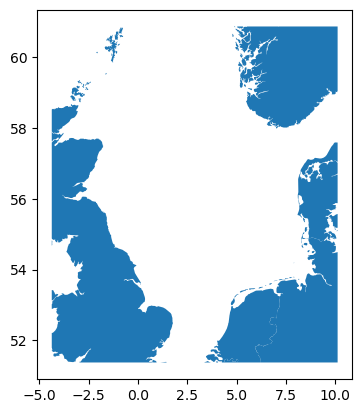

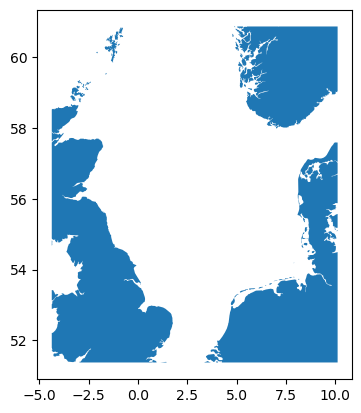

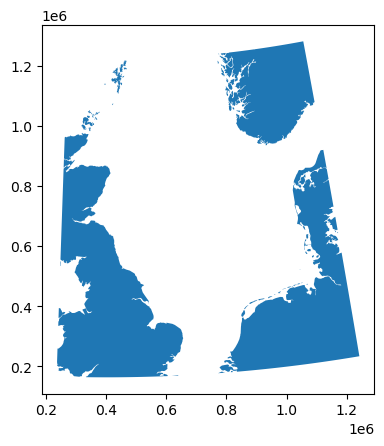

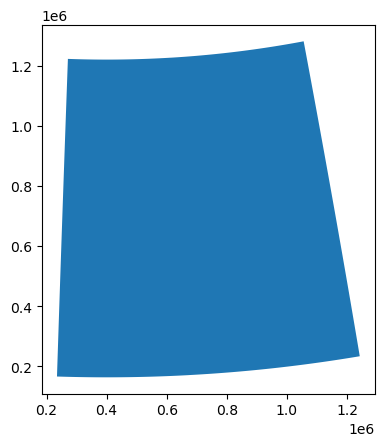

In [6]:
#hier Reduktion auf den Cutout-Ausschnitt mittels helper
shpfilename = shpreader.natural_earth(resolution='10m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)

BorderingStates_init = gpd.GeoSeries({r.attributes['NAME_EN']: r.geometry
                      for r in reader.records()},
                     crs={'init': 'epsg:4326'}
                     ).reindex(['United Kingdom', 'Denmark','Germany','Norway','France','Netherlands','Belgium']) 

helper = gpd.GeoDataFrame(geometry=BorderingStates_init.geometry)#.reset_index().rename(columns={'index':'Countries'})#so kommt man zu Index
helper.to_crs(4326) #komischerweise lässt sich das crs oben nicht übergeben
helper= helper.clip(poly)
helper.plot()
inland= helper.dissolve() #dissolve works only with GPDFs, unary_union returns a Multiploygon#coast0
inland.plot()
inland=inland.to_crs(27700)
inland.plot()
poly=poly.to_crs(27700)
poly.plot()
#poly.iloc[0].geometry.wkt ist sehr lang



In [7]:

marin2= marin1.clip(poly)
marin3 = marin2.overlay(inland, how='difference')#there is few data on the Thames estuary

spa2=spa1.clip(poly)
spa3=spa2.overlay(inland, how='difference') #this dataset contains inland areas

sac2= sac1.clip(poly)
sac3= sac2.overlay(inland, how='difference') #there is data on the inland


(0.0, 1000000.0)

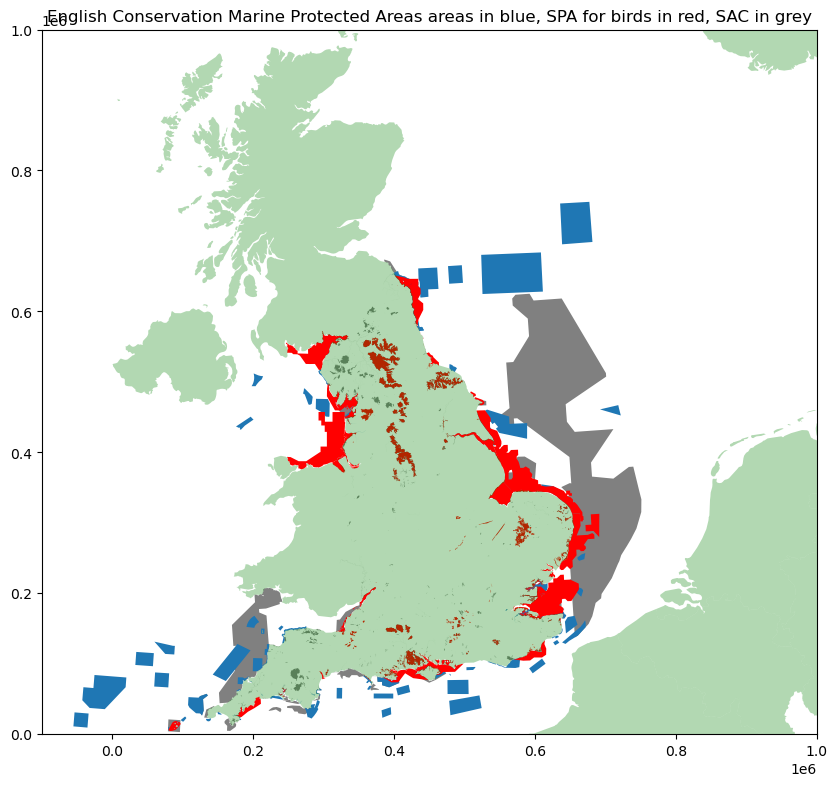

In [17]:

fig, ax =plt.subplots(1,1,figsize=(10,10))
marin1.plot(markersize=0.5,ax=ax)
spa1.plot(color='red',ax=ax)
sac1.plot(color='grey',ax=ax,zorder=0)

helper2 = gpd.GeoDataFrame(geometry=BorderingStates_init[0:7].geometry)
helper2.to_crs(27700).plot(ax=ax,color='green',alpha=.3)
ax.set_title("English Conservation Marine Protected Areas areas in blue, SPA for birds in red, SAC in grey")

#Bouvet, a tiny Norwegian island, Curacao, and French Guyana are included in the original dataset 
#so: limit the axis
ax.set_xlim(-0.1*10**6,1*10**6)
ax.set_ylim(0.0*10**6,1.0*10**6)

<AxesSubplot:title={'center':'MCZ in blue, SPA in red, SAC in grey'}>

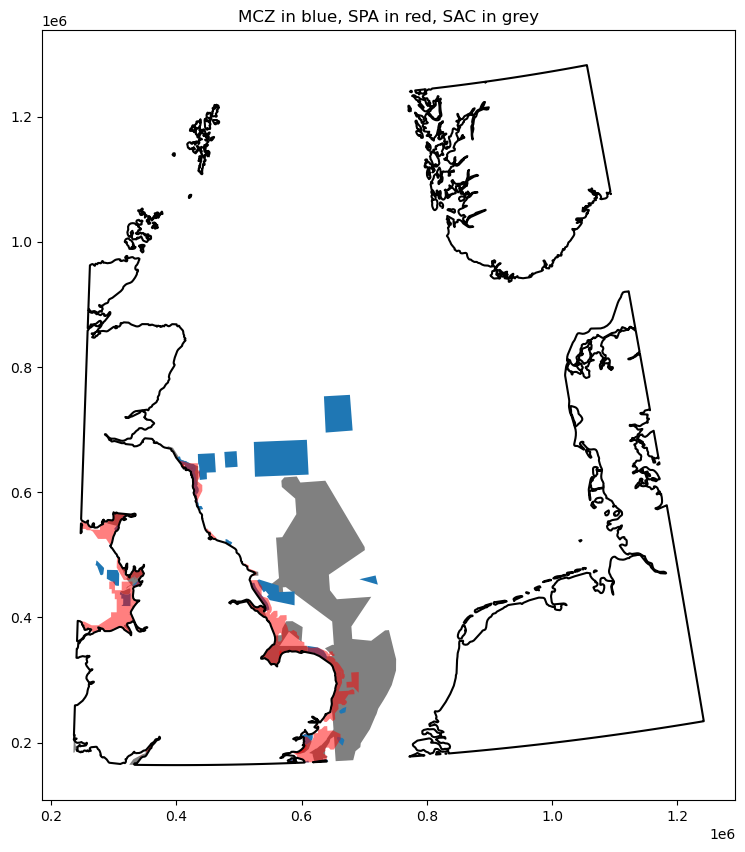

In [9]:
fig, ax =plt.subplots(1,1,figsize=(10,10))
ax.set_title('MCZ in blue, SPA in red, SAC in grey')

inland.boundary.plot(color='black',ax=ax)
sac3.plot(ax=ax,color='grey')
marin3.plot(ax=ax,zorder=1)
spa3.plot(ax=ax,color='red',zorder=1,alpha=0.5)

In [10]:
sac3['TYPE']='SAC_EN'
sac3.columns


Index(['SAC_NAME', 'SAC_CODE', 'SAC_AREA', 'GRID_REF', 'EASTING', 'NORTHING',
       'LATITUDE', 'LONGITUDE', 'NAME', 'STATUS', 'ID', 'FILE_', 'AREA',
       'EASTING0', 'NORTHING0', 'GIS_DATE', 'VERSION', 'GlobalID', 'geometry',
       'TYPE'],
      dtype='object')

In [11]:
spa3['TYPE']='SPC_EN'
spa3.columns

Index(['SPA_NAME', 'SPA_CODE', 'SPA_AREA', 'GRID_REF', 'EASTING', 'NORTHING',
       'LATITUDE', 'LONGITUDE', 'NAME', 'STATUS', 'ID', 'FILE_', 'AREA',
       'EASTING0', 'NORTHING0', 'GIS_DATE', 'VERSION', 'GlobalID', 'geometry',
       'TYPE'],
      dtype='object')

In [12]:
marin3['TYPE']='MPA_EN'

marin3.columns

Index(['OBJECTID', 'MCZ_NAME', 'MCZ_CODE', 'MCZ_AREA', 'GRID_REF', 'EASTING',
       'NORTHING', 'LATITUDE', 'LONGITUDE', 'STATUS', 'GIS_DATE', 'SHAPE_Leng',
       'SHAPE_Area', 'geometry', 'TYPE'],
      dtype='object')

In [13]:
b= pd.concat([spa3, sac3,marin3])

<AxesSubplot:>

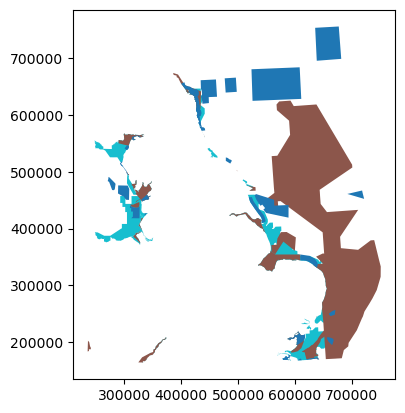

In [14]:
b.head()
b.plot(column='TYPE')


In [15]:
b.to_file(filename=r"..\data\protected_areas_shapefiles\protected_areas_EN.gpkg", driver='GPKG')  

## 